# Part 1: Detecting a Broken Tool

### Overview

This dataset contains the complete sound profiles of sixteen tools for cycles 438-444 and 447 (and 448) (excluding the 3D probe data). Prior knowledge tells us that one of the tools exhibited an anomaly in cycle 439, and which also affected the cycles 440-444. The goal of this investigation is then to determine which of the sixteen tools is anomalous. Thus, the end goal of this investigation is well-defined. However, the intermediate questions and assumptions we must adopt to lead us to the correct conclusion, are not. 

The most central question is, what should we define as anomalous behaviour? Namely, we must understand how the breaking of the tool presents itself within our data. Some possibilities could include a total failure of the machine, in which case we would want to look for a possible sharp spike followed by no further signal. A broken tool could also just be working much slower than expected, meaning we could also be looking for a lag between cycles. Another situtation could be when the tool is broken because it simply skips over one stage of the process and just moves on to the next one. Each type of anomaly would therefore 'looks different' within the data. Since we do not have prior information about the nature of the anomaly, our methods of detection should cast a wide enough net to probe the system for these different types of anomalies.

To obtain a better understanding of what the anomaly could look like, we performed an initial exploration of the dataset. Immediately, we noticed that the most striking feature of the signals are their overall shapes: each tool possesses a unique pattern of spikes and 'blocks' of sound of varying order, number, and duration. This led to the insight that the most relevant information about the tools could be captured within their sequences of sound shapes. To achieve this, we transformed the raw signal into the root-mean-square (rms) value of the signal at each point. This transform does indeed emphasise the 'block' structure that we are interested in exploring, but at the sacrifice of frequency information: the raw signal is composed of a multitude of high frequency (noisy) oscillations that band close together to create these 'macroscopic' patterns. By only considering the amplitude representation of the signal at a point, we lose information about the (high) frequencies present within the signal. This could then make us blind to any anomalies in the frequency spectrum of our signals -- for example, if a tool is broken because it starts to produce a very high screeching sound during one of its routine tasks. Due to these considerations, we will briefly inspect the Fourier transform of our signals. 

Moving forward with the rms-representation, we applied a smoothing technique it to reduce the noise present from amplitude fluctations in the raw signal. This further helps to capture as much of the fundamental structure of the signal. By 'aligning' the signals from a common starting point, we could then plot the (absolute) value of the residuals between a good cycle (non-anomalous cycle 438) and (potentially) bad cycle (any of the 439-444 cycles). This enables us to visually spot any underlying patterns/ mismatch between the signals. 

We choose two types of metrics to quantify the level of deviation/ agreement between two cycles. The first type is to measure 'instantaneous' disagreement between two signals which will be sensitive to lags and anomalous spike structures. The chosen metrics is the root-mean-squared-difference (RMSD), which is given by the root of the sum of the rms residual at a point squared, divided by the total number of data points. We also compute the area under the (absolute value) of the residual plot. The second type of metric aims to quantify the overall agreemen in the behaviour of two signal. We propose three metrics: Pearson's correlation test, Cross-Correlation, and Dynamic Time Warping. The latter is an algorithm that can detect the similarity between two signals, even when they are phase shifted or 'stretched out' (e.g., detecting the similarity between the waveform corresponding to saying a word quickly and saying the same word but slowly.)

By computing the aforementioned metrics for each of the tools, we can observe outliers in the data by performing a PCA and K-means clustering. This step relies on the assumption that non-anomalous cycles have the same order of magnitude of error/ correlation between the two cycles whereas the anomalous will exhibit extremal values, i.e. a much higher RMSD or a much lower cross-correlation than the rest of the tools. 


### Other Key Technical Assumptions
* We are assuming that cycle 438 is a good cycle and that no significant precursor events occurred within that cycle before the anomaly occurred in cycle 439
* We are assuming that our method of alignment of signals is valid: by identifying a common feature/ peak at the start of the signal, usually the last of the three/four spikes at the very start, which we interpret as the tool 'starting up'

# –––––––––––––––––––Code–––––––––––––––––––––

In [86]:
# importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import json 
from scipy.io import wavfile
import scipy
from math import pi
import librosa
from scipy import signal
import matplotlib as mpl
import pandas as pd
import pywt
from scipy.signal import correlate
from scipy.stats import pearsonr
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for file processing
cycles = ["CNC1-CARRIER_OP1_V3-031125-0934-438","CNC1-CARRIER_OP1_V3-031125-0952-439 - anomaly", "CNC1-CARRIER_OP1_V3-031125-1010-440", "CNC1-CARRIER_OP1_V3-031125-1035-441",
          "CNC1-CARRIER_OP1_V3-031125-1056-442", "CNC1-CARRIER_OP1_V3-031125-1115-443", "CNC1-CARRIER_OP1_V3-031125-1133-444", "CNC1-CARRIER_OP1_V3-031125-1336-447 new tools", "CNC1-CARRIER_OP1_V3-031125-1512-448"]

tools = ["01-3D_PROBE.wav", "02-1_2_BEM_4FL_1.625HO_1.25LOC.wav", "03-1_4_90_SPOT_CH_1.375HO_.02F.wav", "04-5_64_DRILL_COB_1.125HO.wav", "05-1_2_BEM_4FL_1.625HO_1.25LOC.wav", "06-1_4_BEM_4FL_1.75HO_.75LOC.wav", "07-1_8_BEM_3FL_.8HO_.75LOC.wav",
         "08-1_2_EM_4FL_2.5HO_1.75LOC.wav", "09-1_2_EM_4FL_1.625HO_1.25LOC.wav", "10-1_4_EM_4FL_1.75HO_.75LOC.wav", "11-1_8_EM_3FL_.8HO_.75LOC.wav", "12-1_4_90_SPOT_CH_1.375HO_.02F.wav",
         "13-11_64_DRILL_COB_2.2HO.wav", "14-NO19_DRILL_1.375HO.wav", "15-1_8_DRILL_1.375HO.wav", "16-1_8_EM_3FL_1.3HO_.8LOC.wav", "17-3_64_CENTER_DRILL.wav", "18-1_16_CH_MILL_1.0HO.wav", 
        "19-3D_PROBE.wav", "power vibration data 0934 438.csv"]

powerdata = ["power vibration data 0934 438.csv", "power vibration data 0952 439.csv", "power vibration data 101 440.csv", "power vibration data 1035 441.csv", "power vibration data 1056 442.csv",
             "power vibration data 1115 443.csv", "power vibration data 1133 444.csv", "power vibration data 1336 447.csv", "power vibration data 1512 448.csv"]

velodata = ["powervibrationdataVELO_438.csv", "powervibrationdataVELO_439.csv", "powervibrationdataVELO_440.csv", "powervibrationdataVELO_441.csv", "powervibrationdataVELO_442.csv",
            "powervibrationdataVELO_443.csv", "powervibrationdataVELO_444.csv", "powervibrationdataVELO_445.csv", "powervibrationdataVELO_446.csv"]

#### Defining Functions

In [87]:
sr=22050 # all the WAV files have same samplerate

# a simple wave denoising/ smoothing algorithm (auto-generated)
def wavelet_denoise(signal, wavelet='db4', level=3, threshold_method='universal'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    detail_coeffs_highest = coeffs[-1]
    sigma = np.median(np.abs(detail_coeffs_highest)) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    new_coeffs = [coeffs[0]] 
    for detail_level in coeffs[1:]:
        new_detail = pywt.threshold(detail_level, value=threshold, mode='soft')
        new_coeffs.append(new_detail)
    denoised_signal = pywt.waverec(new_coeffs, wavelet)
    denoised_signal = denoised_signal[:len(signal)]

    return denoised_signal

# file processing 
def load_waveform(cycle, tool):
    data, sr = librosa.load(f"{cycle}/{tool}")
    time = np.arange(len(data)) / sr
    return data, time

# for plotting signals
def plot(times, signals):
    n = len(signals)
    fig, ax = plt.subplots(n, figsize=(10,5))
    for (axis, signal, time) in zip(ax.ravel(), signals, times):
        axis.plot(time, signal)
        axis.set_xlabel("Time (s)")
        axis.set_ylabel("Amplitude (normalized)")
    return ax

# for aligning signals by finding a common peak structure and cutting both peaks to start at this point and have same total length
def alignment(sound, time, lower, upper):
    placeholder = np.zeros(sound.shape)
    mask = ((time < upper) & (time > lower))
    placeholder[mask] = sound[mask]
    peak_index = np.argmax(placeholder)
    aligned_signal = sound[peak_index:]
    return aligned_signal

# calculating rms for signal
def convert_to_RMS(sound):
    frame_length = 1024  # samples per frame
    hop_length = 512 
    rms = librosa.feature.rms(y=sound, frame_length=frame_length, hop_length=hop_length)[0] 
    return rms

# computing RMSD 
def compute_RMSD(sound1, sound2):
    N = len(sound1)
    rmsd = np.sqrt(np.sum((sound1 - sound2)**2) /N)
    return rmsd

# integral of total error
def compute_normalized_AUC(reference, residual):
    return np.trapz(residual, np.arange(len(residual)))/np.trapz(reference, np.arange(len(reference)))

# computing correlation of signals
def compute_correlation(sound1, sound2):
    # this assumed no lag 
    corr, p = pearsonr(sound1, sound2)
    return corr, p

# computing unnormalized cross-correlation; using the lag value to validate alignments
def compute_cross_corr(sound1, sound2):
    sound1 -= np.mean(sound1)
    sound2 -= np.mean(sound2)
    xcorr = correlate(sound1, sound2, mode='full', method='auto')
    norm_factor = np.sqrt(np.sum(sound1**2) * np.sum(sound2**2))
    maximal_xcorr, index = (np.max(xcorr), np.argmax(xcorr))
    lag = index - (len(sound2) - 1)
    return maximal_xcorr / norm_factor, lag



def run_analysis(good_cycle, bad_cycle, tool, good=438, bad=439, active=False):
    good_signal, t1 = load_waveform(good_cycle, tool)
    bad_signal, t2 = load_waveform(bad_cycle, tool)

    # aligning the signals -- need to manually input the range of the peak which you want to use to align
    aligned_good =  alignment(good_signal, t1,0, 4)
    aligned_bad = alignment(bad_signal, t2, 0, 4)
    cut = np.min([len(aligned_good), len(aligned_bad)]) - 1
    aligned_good = aligned_good[:cut]
    aligned_bad = aligned_bad[:cut]
    t = np.arange(len(aligned_good)) / sr # realigning the time

    # computing rms and smoothing
    rms_good = convert_to_RMS(aligned_good)
    rms_bad = convert_to_RMS(aligned_bad)

    rms_good_clean = wavelet_denoise(rms_good, level=5)
    rms_bad_clean = wavelet_denoise(rms_bad, level=5)

    rmsd = compute_RMSD(rms_good_clean, rms_bad_clean)
    auc = compute_normalized_AUC(rms_good_clean, np.abs(rms_good_clean - rms_bad_clean))
    corr, p = compute_correlation(rms_good_clean, rms_bad_clean)
    xcorr, lag = compute_cross_corr(rms_good_clean, rms_bad_clean)
    dtw = fastdtw(rms_good_clean, rms_bad_clean)[0]

    if active:
        ax1, ax2 = plot([t1,t2], [good_signal, bad_signal]) # plotting raw signal
        ax1.set_title(f"Raw Signal, {good}")
        ax2.set_title(f"Raw Signal, {bad}")
        plt.tight_layout()
        ax1, ax2 = plot([t, t], [aligned_good, aligned_bad])
        ax1.set_title(f"Aligned Signal, {good}")
        ax2.set_title(f"Aligned Signal, {bad}")
        plt.tight_layout()
        ax1, ax2, ax3 = plot([np.arange(len(rms_good_clean)), np.arange(len(rms_bad_clean)), np.arange(len(rms_good_clean))], [rms_good_clean, rms_bad_clean, np.abs(rms_good_clean - rms_bad_clean)])
        ax1.set_title(f"Smoothed RMS Signal {good}")
        ax2.set_title(f"Smoothed RMS Signal {bad}")
        ax3.set_title("Absolute Value Residual of RMS")
        plt.tight_layout()
        plt.show()

    return rmsd, auc, corr, xcorr, lag, dtw



## Comparing Cycles 438 and 439

_____________Analysis for Tool #1: 02-1_2_BEM_4FL_1.625HO_1.25LOC.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.1155842305932299
AUC:  0.1286394437390643
CORR:  0.8599315532282915
XCORR:  0.8624525
Maximal XCorr at Lag:  -2
Dynamic Time Warping 'distance':  45.57571217417717
*********************************************************
_____________Analysis for Tool #2: 03-1_4_90_SPOT_CH_1.375HO_.02F.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.01974472638073369
AUC:  0.06958872021183266
CORR:  0.9643479727919984
XCORR:  0.9676502
Maximal XCorr at Lag:  -1
Dynamic Time Warping 'distance':  2.751791328191757
*********************************************************
_____________Analysis for Tool #3: 04-5_64_DRILL_COB_1.125HO.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.014870695212221443
AUC:  0.06155744114550102
CORR:  0.9767660104056282

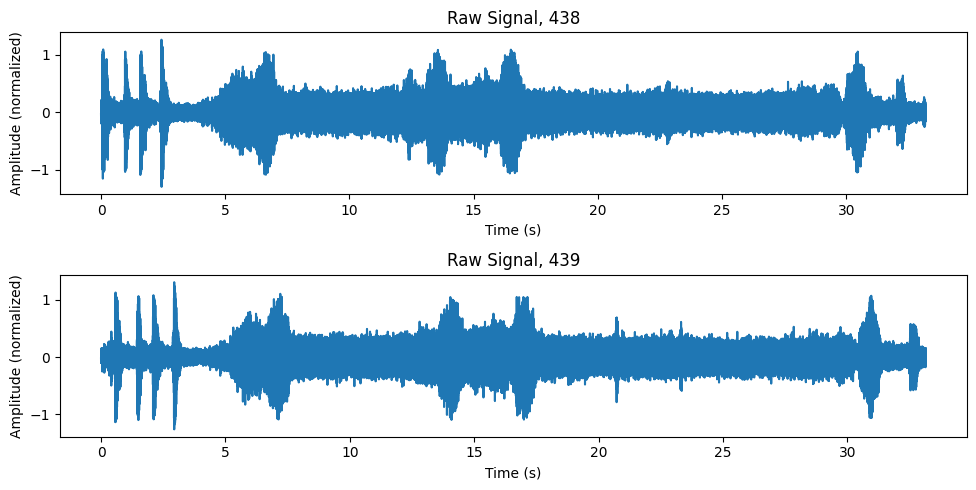

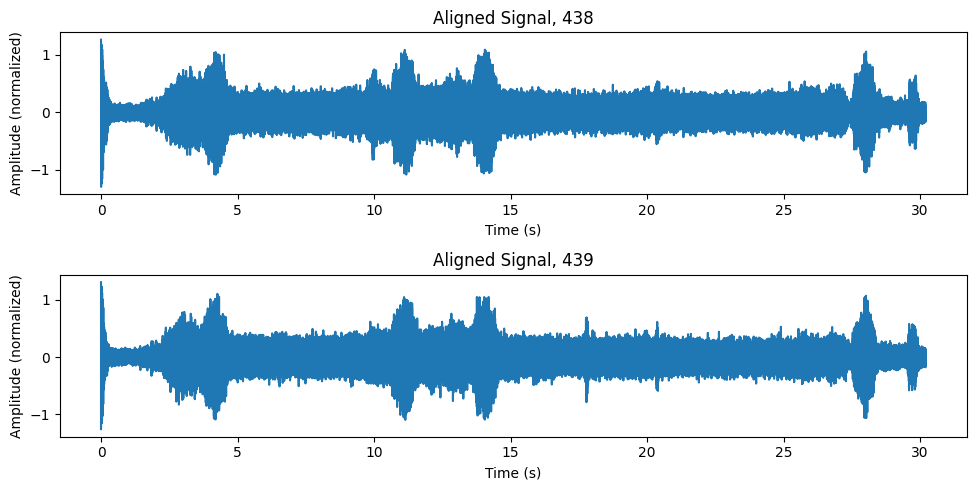

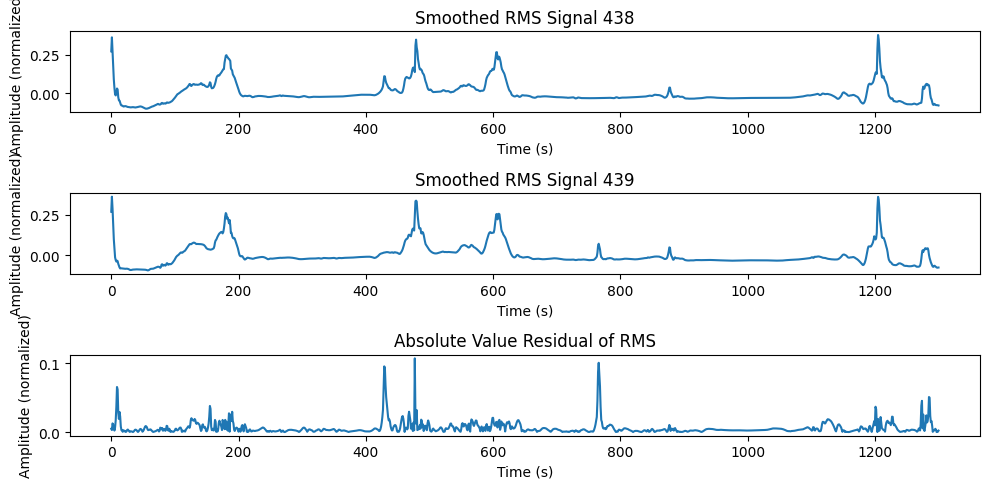

_______________________Analysis Summary______________________
RMSD:  0.011319227130711733
AUC:  0.04533813389306846
CORR:  0.9846707250291746
XCORR:  0.9846706
Maximal XCorr at Lag:  0
Dynamic Time Warping 'distance':  4.649971924722195
*********************************************************
_____________Analysis for Tool #12: 13-11_64_DRILL_COB_2.2HO.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.06925888140145883
AUC:  0.28881382123852883
CORR:  0.3252949490416527
XCORR:  0.78894
Maximal XCorr at Lag:  20
Dynamic Time Warping 'distance':  5.957871995866299
*********************************************************
_____________Analysis for Tool #13: 14-NO19_DRILL_1.375HO.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.01687682170801789
AUC:  0.06695506187502914
CORR:  0.975263701620242
XCORR:  0.97526366
Maximal XCorr at Lag:  0
Dynamic Time Warping 'distance':  2.99373859167099
******

In [145]:
# we first look at how cycle 438 compares to cycle 439; later on, we will look at how cycle 447 compares to 439 since 447 is the other good one
good_cycle = cycles[0]
bad_cycle = cycles[1]

RMSD = []
AUC = []
CORR = []
XCORR = []
LAG = []
DTW = []
for i, tool in enumerate(tools[1:-2]):
    active = True if i == 10 else False # we present only the first 5 plots, which are most relevant to the discussion, to avoid cluttering
    print(f"_____________Analysis for Tool #{i+1}: {tool}_____________________ ")
    rmsd, auc, corr, xcorr, lag, dtw = run_analysis(good_cycle, bad_cycle, tool, active=active)
    RMSD.append(rmsd)
    AUC.append(auc)
    CORR.append(corr)
    XCORR.append(xcorr)
    LAG.append(lag)
    DTW.append(dtw)
    print("_______________________Analysis Summary______________________")
    print("RMSD: ", rmsd)
    print("AUC: ", auc)
    print("CORR: ", corr)
    print("XCORR: ", xcorr)
    print("Maximal XCorr at Lag: ", lag)
    print("Dynamic Time Warping 'distance': ", dtw)
    print("*********************************************************")

X = np.array( [ np.array([RMSD[i], AUC[i], CORR[i], XCORR[1], DTW[i]]) for i in range(len(RMSD) -1)])

## Comparing Cycles 447 and 439

In [155]:
good_cycle = cycles[-2]
bad_cycle = cycles[1]

RMSD = []
AUC = []
CORR = []
XCORR = []
LAG = []
DTW = []
for i, tool in enumerate(tools[1:-2]):
    #active = True if i == 6 else False
    print(f"_____________Analysis for Tool #{i+1}: {tool}_____________________ ")
    rmsd, auc, corr, xcorr, lag, dtw = run_analysis(good_cycle, bad_cycle, tool, good=447, active=active)
    RMSD.append(rmsd)
    AUC.append(auc)
    CORR.append(corr)
    XCORR.append(xcorr)
    LAG.append(lag)
    DTW.append(dtw)
    print("_______________________Analysis Summary______________________")
    print("RMSD: ", rmsd)
    print("AUC: ", auc)
    print("CORR: ", corr)
    print("XCORR: ", xcorr)
    print("Maximal XCorr at Lag: ", lag)
    print("Dynamic Time Warping 'distance': ", dtw)
    print("******************************************************")

Y = np.array( [ np.array([RMSD[i], AUC[i], CORR[i], XCORR[1], DTW[i]]) for i in range(len(RMSD) -1)])


_____________Analysis for Tool #1: 02-1_2_BEM_4FL_1.625HO_1.25LOC.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.18263331904050512
AUC:  0.6348417384813758
CORR:  0.7831147614430403
XCORR:  0.7831148
Maximal XCorr at Lag:  0
Dynamic Time Warping 'distance':  172.71168939769268
******************************************************
_____________Analysis for Tool #2: 03-1_4_90_SPOT_CH_1.375HO_.02F.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.017210759095834603
AUC:  0.0739743900935685
CORR:  0.9747654135213054
XCORR:  0.9747655
Maximal XCorr at Lag:  0
Dynamic Time Warping 'distance':  2.4446570426225662
******************************************************
_____________Analysis for Tool #3: 04-5_64_DRILL_COB_1.125HO.wav_____________________ 
_______________________Analysis Summary______________________
RMSD:  0.020080552917113897
AUC:  0.09711679484810984
CORR:  0.9768791801965829
XCOR

## Comments/ Observations

* Tool 1: we see a very large area of residuals near the start of the signal: cycle 438 and 447 both have a very sharp rise in the signal at about ≈10s whereas cycle 439 seems to have a more gradual/ noisy rise in signal. This could be indicative of an anomaly: given that the signal is messier, this could be due to the tool wearing down and becoming less efficient. This makes tool 1 a candidate for the anomalous/ worn down tool.
* Tool 4: observe the evident decrease in rms in the peaks 0 - 1000 and 2000-4000 in cycle 447 compared to cycle 439. Not only does the amplitude decrease but also the shapes of the peaks before much smoother. The cycle 438 looks much more similar than 439, possibly suggesting that this tool was replaced by a newer one that is more efficient and makes less noise. Another piece of evidence to support this is that looking at the cycles 438-444, we observe that the rms amplitude of the spikes increases. This aligns with the possibility of a worn out tool because a greater amplitude corresponds to a louder sound and hence more energy lost from the machine in the form of vibrations, thus making it less efficient/ worn out. This makes tool 4 a candidate for the worn out tool. 
* Tool 5: in cycles 438 and 447, we see that there are two strong peaks at ≈20s. However, this feature is entirely missing in cycle 439, suggesting that the tool simply skipped an entire step in the cycle and hence tool 5 is also a strong candidate for the anomalous tool. However, for all subsequent cycles 440-444, the feature is present. This then goes against our prior knowledge because we were told that the anomalous tool has bad data for susequent cycles too. 

## Making Sense of the Metrics

In [157]:
def combine_metrics(X, xlim=[-10, 50], k=3):

      # number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X[:,[2,3,4]])

    labels = kmeans.labels_           # cluster labels for each sample
    cluster_centers = kmeans.cluster_centers_

    print("Cluster labels for each tool (0-based):", labels)


    for cluster_id in range(k):
        cluster_indices = np.where(labels == cluster_id)[0]  
        tool_names = [f"tool{idx+1}" for idx in cluster_indices]
    
        print(f"Cluster {cluster_id} contains: {tool_names}")

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)  # shape: (15, 2)


    #plt.scatter(X_2d[:, 0], X_2d[:, 1]) #, c=labels)
    #plt.title("K-means Clusters (visualized in 2D PCA space)")
    #plt.xlabel("Principal Component 1")
    #plt.ylabel("Principal Component 2")
    #plt.scatter(X_2d[3, 0], X_2d[3, 1], label='Tool ', color='red', marker='X')
    #plt.scatter(X_2d[0, 0], X_2d[0, 1], label='Tool 1', color='purple', marker='X')
    #plt.scatter(X_2d[3, 0], X_2d[3, 1], label='Tool 4', color='black', marker='X')
    #plt.scatter(X_2d[4, 0], X_2d[4, 1], label='Tool 5', color='green', marker='X')
    #plt.scatter(X_2d[6, 0], X_2d[6, 1], label='Tool 7', color='red', marker='X')
    #plt.scatter(X_2d[7, 0], X_2d[7, 1], label='Tool 8', color='yellow', marker='X')
    #plt.scatter(X_2d[10, 0], X_2d[10, 1], label='Tool 10', color='magenta', marker='X')
    #plt.legend()
    #plt.xlim(xlim)
    #plt.ylim([-10, 10])
    #plt.show()
    return X_2d[:,0]



combine_metrics(X, k=4)
combine_metrics(Y, k=4)

Cluster labels for each tool (0-based): [2 0 0 1 1 0 1 3 0 0 0 0 0 0 3 0]
Cluster 0 contains: ['tool2', 'tool3', 'tool6', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool16']
Cluster 1 contains: ['tool4', 'tool5', 'tool7']
Cluster 2 contains: ['tool1']
Cluster 3 contains: ['tool8', 'tool15']
Cluster labels for each tool (0-based): [0 1 1 2 3 1 3 3 1 1 1 1 1 1 1 1]
Cluster 0 contains: ['tool1']
Cluster 1 contains: ['tool2', 'tool3', 'tool6', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool15', 'tool16']
Cluster 2 contains: ['tool4']
Cluster 3 contains: ['tool5', 'tool7', 'tool8']


/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([124.39337338, -45.87431443, -42.77798768, 334.81257992,
       -18.32122656, -41.83201112,  -7.28917365,  20.09491584,
       -38.76128214, -39.35314973, -42.86421549, -43.3337187 ,
       -44.07636146, -45.18000711, -29.64612003, -39.99130103])

## Discussion

There are several interesting features within this plot. Firstly, we see that along the x-axis (the first principal component), the data points vary two orders of magnitude greater than across the y-component. This tells us that our data posesses a single principal component that is much more significant compared to other principle components. We can therefore effectively treat the plots as one dimensional and hence enables us to derive a ranking of the most likely anomalies. We see that, disregarding Tools 1 and 4, the next most anomalous Tools appear to be identified as Tools 7 and Tool 8. 
To better get a sense of which tool is the broken one, we can perform this 'PCA ranking' for a comparison of cycle 438 which each of cycles 439-444, as well as comparing them cycle 447 with cycle. From this analysis, we find that when comparing with Cycle 438, Tool 7 is consistently ranked as the highest. However, when comparing with Cycle 447, Tool 8 is ranked as the highest. The code below corresponds to this analysis for 447. It is not fully clear as to why the two supposedly equally 'good' cycles produce different results given that they should be consistent with one another. Note also that the same Tools are consistently in the top 6 positions.

In [158]:
def run_cycle(good_cycle, bad_cycle):
    RMSD = []
    AUC = []
    CORR = []
    XCORR = []
    LAG = []
    DTW = []
    for i, tool in enumerate(tools[1:-2]):
        #active = True if i == 6 else False
        rmsd, auc, corr, xcorr, lag, dtw = run_analysis(good_cycle, bad_cycle, tool, good=447)
        RMSD.append(rmsd)
        AUC.append(auc)
        CORR.append(corr)
        XCORR.append(xcorr)
        LAG.append(lag)
        DTW.append(dtw)
        #print("_______________________Analysis Summary______________________")
        #print("RMSD: ", rmsd)
        #print("AUC: ", auc)
        #print("CORR: ", corr)
        #print("XCORR: ", xcorr)
        #print("Maximal XCorr at Lag: ", lag)
        #print("Dynamic Time Warping 'distance': ", dtw)
        #print("******************************************************")

    Y = np.array( [ np.array([RMSD[i], AUC[i], CORR[i], XCORR[1], DTW[i]]) for i in range(len(RMSD) -1)])

    principal_component = combine_metrics(Y)
    print("Ranking:", 1 + np.argsort(principal_component)[::-1])

for cycle in cycles[1:5]:
    run_cycle(cycles[-2], cycle)

/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels for each tool (0-based): [2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster 0 contains: ['tool2', 'tool3', 'tool5', 'tool6', 'tool7', 'tool8', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool15', 'tool16']
Cluster 1 contains: ['tool4']
Cluster 2 contains: ['tool1']
Ranking: [ 4  1  8  7  5 15  9 10 16  6  3 11 12 13 14  2]


/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels for each tool (0-based): [2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster 0 contains: ['tool2', 'tool3', 'tool5', 'tool6', 'tool7', 'tool8', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool15', 'tool16']
Cluster 1 contains: ['tool4']
Cluster 2 contains: ['tool1']
Ranking: [ 4  1  8  7 15  5 10 16  9  6  3 11 12 13 14  2]


/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels for each tool (0-based): [2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster 0 contains: ['tool2', 'tool3', 'tool5', 'tool6', 'tool7', 'tool8', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool15', 'tool16']
Cluster 1 contains: ['tool4']
Cluster 2 contains: ['tool1']
Ranking: [ 4  1  8  7 15 10 11  5  9  6 16  3 12 13 14  2]
Cluster labels for each tool (0-based): [2 0 0 1 0 0 2 2 0 0 0 0 0 0 0 0]
Cluster 0 contains: ['tool2', 'tool3', 'tool5', 'tool6', 'tool9', 'tool10', 'tool11', 'tool12', 'tool13', 'tool14', 'tool15', 'tool16']
Cluster 1 contains: ['tool4']
Cluster 2 contains: ['tool1', 'tool7', 'tool8']
Ranking: [ 4  1  8  7 15  5 16  9 10  6  3 11 13 12 14  2]


/Users/kat/anaconda3/envs/ph21/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Part 2: Detecting the Worn Out Tool

The second part of the investigation is to detect a worn out tool. As before, the central question to address before we define our approach is how does wearing present itself in the data? Unlike with anomalies, we have a much better idea for the physical origin of wearing: wearing can occur when a tool is under a lot of strain, and manifests itself in the form of greater energy expenditure as the tool becomes less efficient. Since our data only relates to sound, it is natural to look for this greater energy loss in the form of mechanical vibration losses. Specifically, within our data we should be looking for rising peak amplitudes across cycles. Furthermore, our dataset includes information on power and velocity of the vibrations, which directly relate to measures of energy. It is therefore most sensible to use this as our primary data source. Indeed, we proceed by measuring the total velocity of the vibrations and calculate the total energy of the cycle by taking the integral over the many cycles. After performing these studies on all the tools, we present the most compelling candidate : Tool 4 in the above notation, which corresponds to "1_2_BEM_4FL_1.625HO_1.25LOC".

Note: there appears to be an issue with labelling of tool 1 and tool 4 in the .WAV files: both tool 1 and tool 4 are labelled: "02-1_2_BEM_4FL_1.625HO_1.25LOC" and "05-1_2_BEM_4FL_1.625HO_1.25LOC". They look like they are distinct tools, though because their signals are so different. By visual judgement, it seems more plausible that the VIB_VELO spectrum below corresponds to Tool 4, though. But this raises the issue of where is the VIB_VELO for Tool 1...

[178.20125017584073, 179.14907379511862, 171.27410337037378, 187.8933966361721, 213.28202415126756, 279.5715264638277, 261.787236113274, 41.85268267384379, 42.2921645530208]


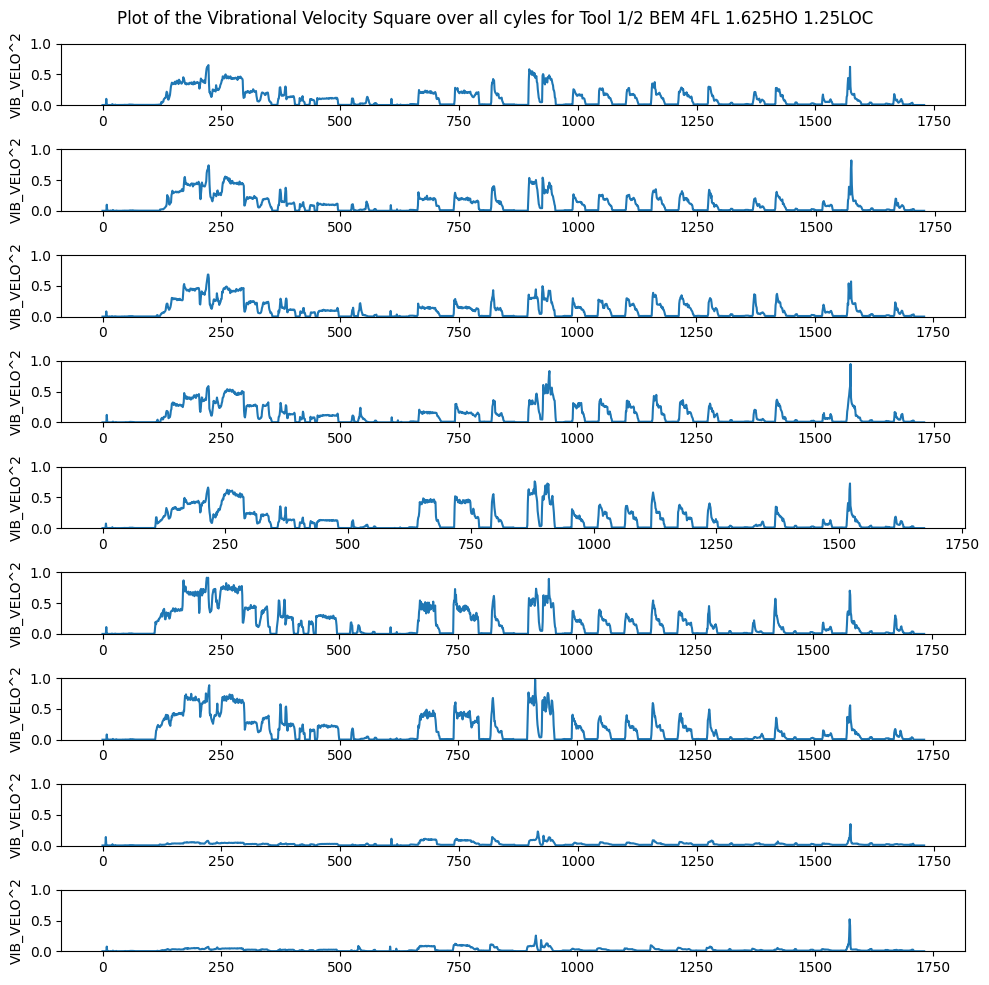

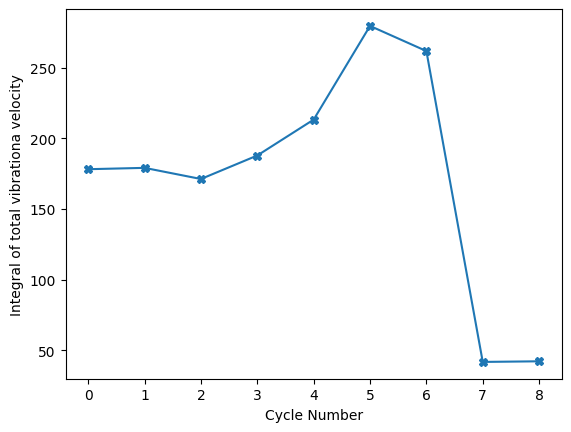

In [20]:
tool = '1/2 BEM 4FL 1.625HO 1.25LOC'

fig, ax = plt.subplots(len(cycles), figsize=(10,10))
energy_data = []
for n, axis in enumerate(ax.ravel()):
    df = pd.read_csv(f"{cycles[n]}/{velodata[n]}")
    vx = df[(df['Tool'] == tool) & (df['VIB_VELO_X'] == 'VIB_VELO_X')]['Value'].values
    vy = df[(df['Tool'] == tool) & (df['VIB_VELO_X'] == 'VIB_VELO_Y')]['Value'].values
    vz = df[(df['Tool'] == tool) & (df['VIB_VELO_X'] == 'VIB_VELO_Z')]['Value'].values
    v = vx**2 + vy**2 + vz**2
    axis.plot(v)
    axis.set_ylim([0,1])
    axis.set_ylabel("VIB_VELO^2")
    total_energy = np.trapz(v, np.arange(len(v)))
    energy_data.append(total_energy)
fig.suptitle(f"Plot of the Vibrational Velocity Square over all cyles for Tool {tool}")
fig.tight_layout()
fig, ax2 = plt.subplots()
ax2.plot(np.arange(len(energy_data)), energy_data, marker='X')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Integral of total vibrationa velocity")
print(energy_data)
plt.show()

From a visual inspection of the first plot, we can readily see that the amplitude of block of non-zero velocity increases over the course of the cycles 438-444. Physically, we interpret this as the machine vibrating more through each stage of the procedure as the cycles progress. We then see that at cycle 447 and onwards, there is a drastic reduction in the vibrational velocity amplitude (the axis scales are all consistent). This is exactly what we would expect if someone were to replace the worn out tool with a new tool, which is exactly what we are told has occurred at cycle 447. 

We can further prove that this wearing increases over time by calculating the integral over the entire cycle. The plot shows the square of the vibrational velocity. Hence, each data point plotted will be proportional to the total energy at a given time. Hence, integrating it over time will give the total energy expended due to vibrations in an entire cycle (in some units). We plot this total energy per cycle in the second plot. We see that up to cycle 7, the energy has an increasing trend from 178 to a maximum of 280. This represents a far greater variation in the total integral than exhibited by any other plot. Moreover, the peak velocity squared for this tool is greater by an order of magnitude compared to many of the other tools. This further supports our conclusion that Tool 4 is indeed the worn out tool.

It is seen that Tool 7 is then the most concistently highly ranked anomalous tool, after Tools 1,4, and 5 which had been ruled out. Looking at the plot for Tool 7, we see that its sound cycle has many peaks, and so since our alignment strategy may be imperfect, it could be the case that the instantaneous disagreement metrics recorded were higher than they should be. Hence we applied PCA pased only on the correlation and DTW metrics, and the same pattern emerged which has helped to solidify our conclusion that Tool 7: "1_2_EM_4FL_2.5HO_1.75LOC" appears to be the most anomalous.

In [144]:
print(tools[7])

08-1_2_EM_4FL_2.5HO_1.75LOC.wav
